# REGRESSION MODELING EXPOSURE AT DEFAULT

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_error
%config IPCompleter.greedy=True
pd.options.display.float_format = '{:.2f}'.format
import warnings
warnings.filterwarnings("ignore")

## UPLOAD DATA

In [2]:
path = '../../'

In [3]:
name = 'df_tablon_ead.pickle'

In [4]:
df = pd.read_pickle(path + '/02_Data/03_Work/' + name)

##  X e Y

In [5]:
x = df.drop(columns='target_ead')
y = df.target_ead

## MODELLING

### validacion dataset

In [6]:
train_x,val_x,train_y,val_y = train_test_split(x,y,test_size=0.3)

### pipe and the dictionary of algorithms, parameters and values to test

In [7]:
pipe = Pipeline([('algorithm',Ridge())])

grid = [      
        {'algorithm': [Ridge()],
         'algorithm__alpha': list(np.arange(0.1,1.1,0.1))},
        
        {'algorithm': [Lasso()],
         'algorithm__alpha': list(np.arange(0.1,1.1,0.1))},
    
        {'algorithm': [HistGradientBoostingRegressor(min_samples_leaf = 100, scoring = 'neg_mean_absolute_percentage_error')],
         'algorithm__learning_rate': [0.01,0.025,0.05,0.1],
         'algorithm__max_iter': [50,100,200],
         'algorithm__max_depth': [5,10,20],
         'algorithm__l2_regularization': [0,0.25,0.5,0.75,1]}
       ]

### Optimize hyper parameters

#### grid search

In [8]:
grid_search = GridSearchCV(estimator= pipe, 
                           param_grid = grid, 
                           cv = 3, 
                           scoring = 'neg_mean_absolute_error',
                           verbose = 0,
                           n_jobs = -1)

model = grid_search.fit(train_x,train_y)

In [13]:
sal = pd.DataFrame(grid_search.cv_results_).sort_values(by = 'rank_test_score').reset_index(drop=True).head(10)
sal

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algoritmo,param_algoritmo__alpha,param_algoritmo__l2_regularization,param_algoritmo__learning_rate,param_algoritmo__max_depth,param_algoritmo__max_iter,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,58.37,2.70,0.84,0.13,HistGradientBoostingRegressor(l2_regularizatio...,NaN,1,0.10,20,200,{'algoritmo': HistGradientBoostingRegressor(l2...,-0.23,-0.24,-0.24,-0.24,0.00,1
1,60.79,1.58,1.17,0.03,HistGradientBoostingRegressor(l2_regularizatio...,NaN,0,0.10,10,200,{'algoritmo': HistGradientBoostingRegressor(l2...,-0.23,-0.24,-0.24,-0.24,0.00,2
2,88.06,3.24,1.60,0.29,HistGradientBoostingRegressor(l2_regularizatio...,NaN,0.50,0.10,20,200,{'algoritmo': HistGradientBoostingRegressor(l2...,-0.23,-0.24,-0.24,-0.24,0.00,3
3,62.66,3.49,1.03,0.02,HistGradientBoostingRegressor(l2_regularizatio...,NaN,1,0.10,10,200,{'algoritmo': HistGradientBoostingRegressor(l2...,-0.24,-0.24,-0.24,-0.24,0.00,4
4,63.63,8.91,1.26,0.18,HistGradientBoostingRegressor(l2_regularizatio...,NaN,0.75,0.10,20,200,{'algoritmo': HistGradientBoostingRegressor(l2...,-0.24,-0.24,-0.24,-0.24,0.00,5
5,62.94,2.24,1.26,0.12,HistGradientBoostingRegressor(l2_regularizatio...,NaN,0.75,0.10,10,200,{'algoritmo': HistGradientBoostingRegressor(l2...,-0.23,-0.24,-0.24,-0.24,0.00,6
6,85.97,6.77,1.35,0.14,HistGradientBoostingRegressor(l2_regularizatio...,NaN,0.25,0.10,10,200,{'algoritmo': HistGradientBoostingRegressor(l2...,-0.23,-0.23,-0.24,-0.24,0.00,7
7,77.94,5.56,1.42,0.16,HistGradientBoostingRegressor(l2_regularizatio...,NaN,0,0.10,20,200,{'algoritmo': HistGradientBoostingRegressor(l2...,-0.24,-0.24,-0.24,-0.24,0.00,8
8,85.94,6.96,1.61,0.28,HistGradientBoostingRegressor(l2_regularizatio...,NaN,0.25,0.10,20,200,{'algoritmo': HistGradientBoostingRegressor(l2...,-0.23,-0.24,-0.24,-0.24,0.00,9
9,70.10,11.11,1.50,0.34,HistGradientBoostingRegressor(l2_regularizatio...,NaN,0.50,0.10,10,200,{'algoritmo': HistGradientBoostingRegressor(l2...,-0.24,-0.24,-0.24,-0.24,0.00,10


The result is the same in all first configurations.

For simplicity we stay with the first.

And we retrain the model with that configuration.

In [10]:
model_ead = HistGradientBoostingRegressor(learning_rate = 0.1,
                                          max_iter = 200,
                                          max_depth = 10,
                                          min_samples_leaf = 100,
                                          scoring = 'neg_mean_absolute_percentage_error',
                                          l2_regularization = 0.75)
model_ead.fit(train_x,train_y)

HistGradientBoostingRegressor(l2_regularization=0.75, max_depth=10,
                              max_iter=200, min_samples_leaf=100,
                              scoring='neg_mean_absolute_percentage_error')

## EVALUATION

### Predict over validation

In [11]:
pred = model_ead.predict(val_x)

Correct the maximums and minimums.

In [12]:
pred = np.where(pred < 0, 0, pred)
pred = np.where(pred > 1, 1, pred)

### Evaluation over  validation

In [13]:
mean_absolute_error(val_y, pred)

0.2370950033550181

## MODEL REPORTING

In [14]:
check_validation = pd.DataFrame({'ead_real':val_y, 'ead_pred':pred})
check_validation

,ead_real,ead_pred
id_cliente,,
70882245,0.68,0.49
77391303,0.06,0.04
111480076,0.00,0.63
113236930,0.00,0.63
16712210,0.00,0.12
...,...,...
20799120,0.00,0.28
59190966,0.00,0.08
127556400,0.67,0.45


In [15]:
check_validation.corr()

,ead_real,ead_pred
ead_real,1.00,0.63
ead_pred,0.63,1.00


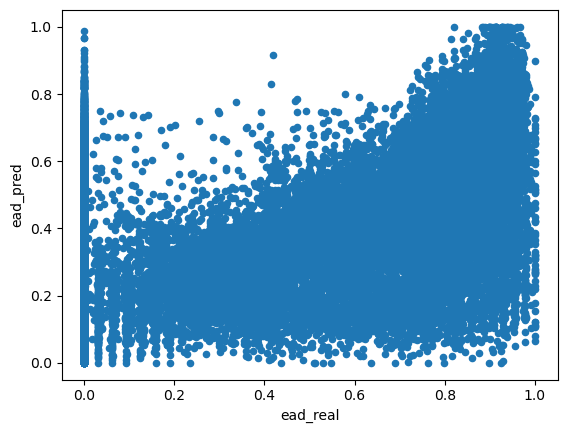

In [16]:
check_validation.plot.scatter(x='ead_real',y='ead_pred');

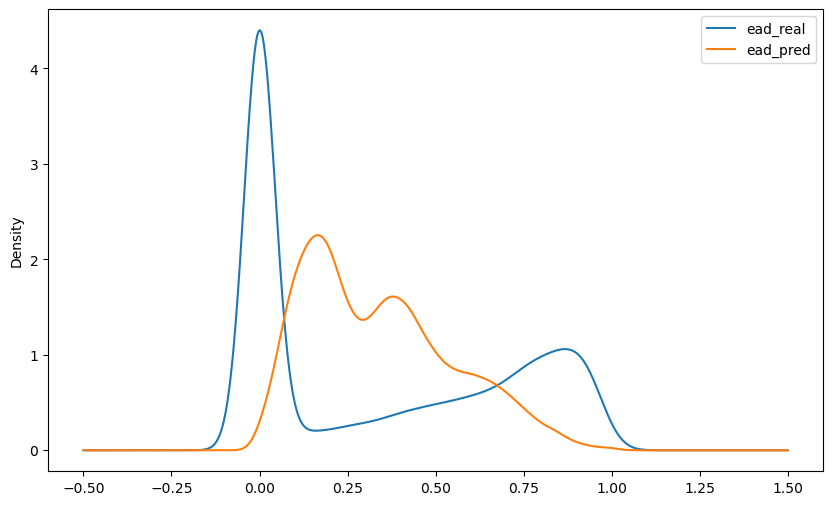

In [17]:
check_validation.plot.density(figsize = (10,6));